In [1]:
# <-------------1.import library ------------->
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# <-------------2.load data ------------->
ds = pd.read_csv("results.csv")

# # <------------- 3.cek stuktur data ------------->
# print("\n5 data teratas:")
# print("\n",ds.head())
# print("\nInformasi umum data:")
# print("\n",ds.info())

#  <------------- 4.ternyata ada missing data------------->
# 1. cek jumlah missing data
# print("\nJumlah missing data:")
# print(ds.isnull().sum())

# cek baris yang memiliki minimal 1 data kosong
missing_rows = ds[ds.isnull().any(axis=1)]
# print("\nBaris yang memiliki minimal 1 data kosong:")
# print(missing_rows)


# karna jumlah <5% total data, kita bisa drop saja
ds_clean = ds.dropna().copy()
# print("\nsetelah DIHAPUS",ds_clean.info())


# koreksi tipe data. date dari object menjadi datetime dan nutral menjadi boolean
ds_clean["neutral"] = ds_clean["neutral"].astype(bool)

ds_clean["date"]= pd.to_datetime(ds_clean["date"])
# print("\n",ds_clean.info())

In [2]:
# LATIHAN PENGULANGAN BOX 1

# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# du = pd.read_csv ("results.csv")
# # print (du.head(), "\n -------------- \n", du.info())
# missing_data = du[ du.isnull().any(axis=1)]
# # print (missing_data)
# du_clean = du.dropna().copy()
# # print (du_clean.info())

# du_clean["date"] = pd.to_datetime (du_clean["date"])
# du_clean["neutral"] = du_clean["neutral"].astype (bool)

# # print (du_clean.info())

In [3]:
#  <------------- 5.Melakukan filtering data pertama------------->

ds_indo = ds_clean[(ds_clean["home_team"] == "Indonesia") | 
                   (ds_clean["away_team"] == "Indonesia")].copy()
# print(ds_indo.head(10))
# print (ds_indo.head(10))

#  <------------- 6.Melakukan filtering data kedua untuk klasifikasi------------->
def classify_match (row):
    # home indonesia, country indonesia, ground netral false
    if ((row["home_team"] == "Indonesia") and 
        (row["country"] == "Indonesia") and
        (row["neutral"]== False)):
        return "home"
    # away indonesia, country != indonesia, ground netral false
    elif ((row["away_team"] == "Indonesia") and 
        (row["country"] != "Indonesia") and
        (row["neutral"]== False)):
        return "away"
    # netral = True
    elif ((row["home_team"]=="Indonesia" or
          row["away_team"]=="Indonesia") and
          (row["neutral"]== True)):
        return "neutral"
    else:
        return "unknown"

# # <------------- 7.Membuat kolom baru untuk klasifikasi------------->

ds_indo["match_type"] = ds_indo.apply(classify_match, axis =1)
# print ("\n",ds_indo["match_type"].value_counts())
# # mengecek yang jumlahnya unknown
# print ("\njumlah yang UNKNOWN adalah",(ds_indo["match_type"]== "unknown" ).sum())

In [4]:
# <------------- 8.Membuat filtering dekade------------->
# tambah kolom year
ds_indo["year"]=ds_indo["date"].dt.year
# print(ds_indo.head(10))
# cek distribusi tahuun pertandingan
# print("cek distribusi tahuun pertandingan:")
# print(ds_indo["year"].value_counts().sort_index())

# membuat kategori dekade dengan fungsi
def create_decade (year):
    decade_start = (year // 10)*10
    decade_end = decade_start + 9
    return f"{decade_start}-{decade_end}"

# membuat fitur decade dan dimasukkkan sesuai dengan ftur year
ds_indo ["decade"]= ds_indo["year"].apply(create_decade)

# print ("\n",ds_indo["decade"].value_counts().sort_index())
# print (ds_indo.head())

In [5]:
# <------------- 9.Membuat kolom hasil(menang/kalah/seri)------------->

# jika indonesia home team  
def determine_result(row):
    # Jika Indonesia home team
    if row['home_team'] == 'Indonesia':
        if row['home_score'] > row['away_score']:
            return 'win'
        elif row['home_score'] < row['away_score']:
            return 'lose'
        else:
            return 'draw'
    # Jika Indonesia away team
    else:
        if row['away_score'] > row['home_score']:
            return 'win'
        elif row['away_score'] < row['home_score']:
            return 'lose'
        else:
            return 'draw'
        
       
# tambah kolom result ke dataframe
ds_indo["result"] = ds_indo.apply(determine_result, axis=1)
# print(ds_indo.head(10))
# print(ds_indo[['date', 'home_team', 'away_team', 'country', 'neutral', 'match_type','decade','result']].head())


In [6]:
# <------------- 10.Analisis per Dekade------------->
# buat pivot table pandas

decade_summary = ds_indo.pivot_table(
    index= 'decade', # rowsnya
    columns='result', # kolomnya
    values='date', # value yang mau diambil
    aggfunc='count', # fungsi agregasi yang mau dipake
    fill_value=0 # nilai pengganti jika kosong
)

# hitung total pertandingan per dekade dan tambahkan fitur ke DataFrame
decade_summary['total_matches'] = decade_summary.sum(axis=1)

# menghitung presentase hasil per dekade
for result_type in ['win', 'lose', 'draw']:
    decade_summary[f'{result_type}_percentage'] = (decade_summary[result_type] / decade_summary['total_matches']) * 100


# print("\n",decade_summary)

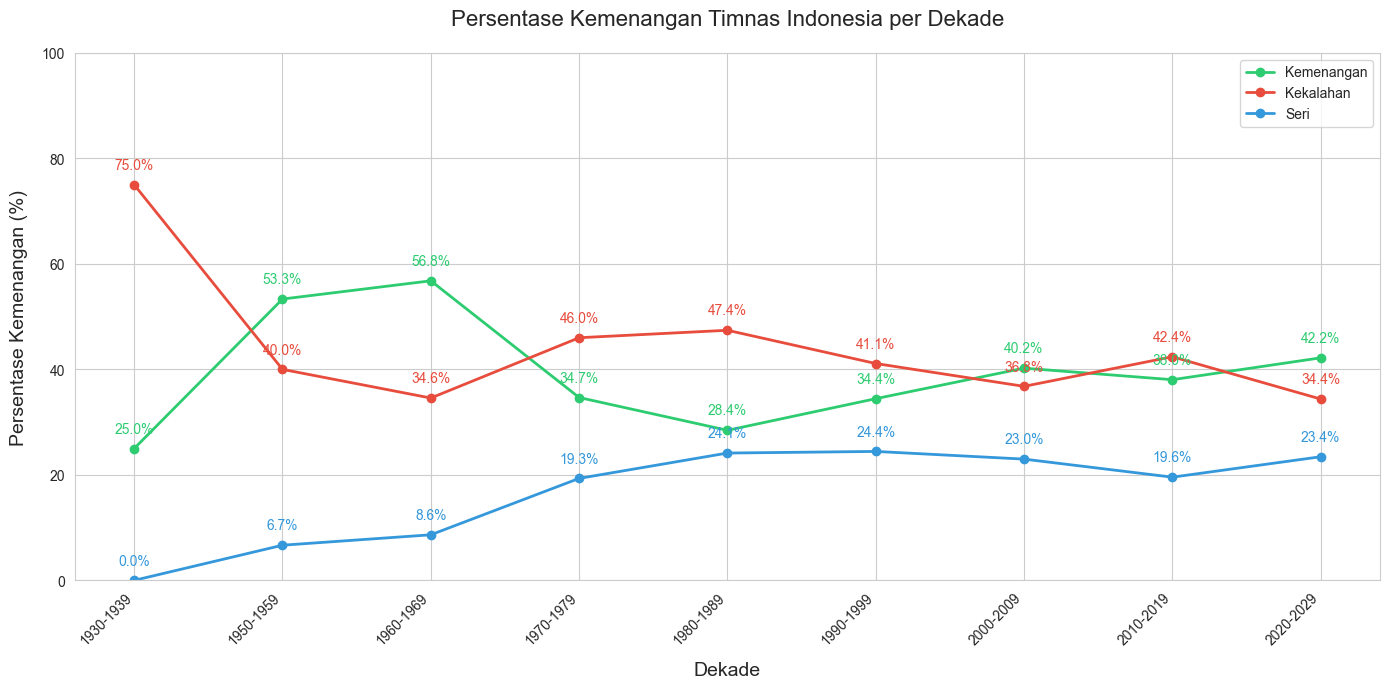

In [16]:
# print(decade_summary.columns.tolist())


# <------------- 11.Visualisasi Data------------->
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
sns.set_palette("pastel")

# plot garis untuk tiap hasil
if 'win_percentage' in decade_summary.columns:
    plt.plot(decade_summary.index, decade_summary['win_percentage'], marker='o', label='Kemenangan', color='#2ecc71', linewidth=2)
if 'lose_percentage' in decade_summary.columns:
    plt.plot(decade_summary.index, decade_summary['lose_percentage'], marker='o', label='Kekalahan', color='#e74c3c',   linewidth=2)   
if 'draw_percentage' in decade_summary.columns:
    plt.plot(decade_summary.index, decade_summary['draw_percentage'], marker='o', label='Seri', color='#3498db',  linewidth=2) 
   

plt.title('Persentase Kemenangan Timnas Indonesia per Dekade', fontsize=16, pad=20)
plt.xlabel('Dekade', fontsize=14, labelpad=10)
plt.ylabel('Persentase Kemenangan (%)', fontsize=14, labelpad=10)
plt.xticks(rotation=45, ha='right') # rotasi label sumbu X
plt.ylim(0, 100) # batas sumbu Y dari 0-100%
plt.legend()

# Tambah label hanya untuk kolom yang ada
for decade in decade_summary.index:
    win = decade_summary.loc[decade, 'win_percentage']
    plt.text(decade, win+3, f'{win:.1f}%', ha='center', color='#2ecc71')
for decade in decade_summary.index:
    lose = decade_summary.loc[decade, 'lose_percentage']
    plt.text(decade, lose+3, f'{lose:.1f}%', ha='center', color='#e74c3c')
for decade in decade_summary.index:
    draw = decade_summary.loc[decade, 'draw_percentage']
    plt.text(decade, draw+3, f'{draw:.1f}%', ha='center', color='#3498db')


plt.tight_layout()
plt.show()

